In [1]:
import iris

以下のようにgribdataそのままでは扱えない

In [2]:
import gribapi

ImportError: No module named 'gribapi'

In [3]:
filename = "/Users/susu/Desktop/インターン、ボランティア/weathernews/GRIB/Z__C_RJTD_20170917000000_GSM_GPV_Rgl_FD0000_grib2.bin"
cubes = iris.load(filename)

RuntimeError: Unable to load GRIB file - the ECMWF `gribapi` package is not installed.

他のデータ形式でなら動くのかを確認

In [2]:
filename = iris.sample_data_path('uk_hires.pp')
cubes = iris.load(filename)
print(cubes)

0: air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)
1: surface_altitude / (m)              (grid_latitude: 204; grid_longitude: 187)


このようにpp形式のようなGRIB以外のファイル形式であればirisが動作する。ではGRIBを外部でppなどに変換できればいいのでは？

### load周り

In [4]:
air_potential_temperature = cubes[0]
print(air_potential_temperature)

air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)
     Dimension coordinates:
          time                           x                      -                 -                    -
          model_level_number             -                      x                 -                    -
          grid_latitude                  -                      -                 x                    -
          grid_longitude                 -                      -                 -                    x
     Auxiliary coordinates:
          forecast_period                x                      -                 -                    -
          level_height                   -                      x                 -                    -
          sigma                          -                      x                 -                    -
          surface_altitude               -                      -                 x                

cubesはlistで、複数のファイルを一度に取り込める。（別々のcubeとしてloadされる。）

In [5]:
# 制約をつけてfileをload
filename = iris.sample_data_path('uk_hires.pp')
cube_all = iris.load_cube(filename, 'air_potential_temperature')
print('All times :\n' + str(cube_all.coord('time')))

All times :
DimCoord([2009-11-19 10:00:00, 2009-11-19 11:00:00, 2009-11-19 12:00:00], standard_name='time', calendar='gregorian')


In [6]:
print(cube_all)

air_potential_temperature / (K)     (time: 3; model_level_number: 7; grid_latitude: 204; grid_longitude: 187)
     Dimension coordinates:
          time                           x                      -                 -                    -
          model_level_number             -                      x                 -                    -
          grid_latitude                  -                      -                 x                    -
          grid_longitude                 -                      -                 -                    x
     Auxiliary coordinates:
          forecast_period                x                      -                 -                    -
          level_height                   -                      x                 -                    -
          sigma                          -                      x                 -                    -
          surface_altitude               -                      -                 x                

In [7]:
# Define a function which accepts a datetime as its argument (this is simplified in later examples).
# 11時のやつとってくる
hour_11 = iris.Constraint(time=lambda cell: cell.point.hour == 11)

In [8]:
# なぜか知らんがextract関数で特定のセルを抜き出す時はwith構文で書く
# extract関数の引数はiris.Constraint classのインスタンス
with iris.FUTURE.context(cell_datetime_objects=True):
    cube_11 = cube_all.extract(hour_11)
    
print('Selected times :\n' + str(cube_11.coord('time')))

Selected times :
DimCoord([2009-11-19 11:00:00], standard_name='time', calendar='gregorian')


In [9]:
# 先のhour_11の中身は、PartialDateTime classを使ってもっと簡単に書けるよ。
# extract使わずとも、Constraint classを直接loadの制約に使うこともできるよ
the_11th_hour = iris.Constraint(time=iris.time.PartialDateTime(hour=11))
with iris.FUTURE.context(cell_datetime_objects=True):
    print(iris.load_cube(iris.sample_data_path('uk_hires.pp'),'air_potential_temperature' & the_11th_hour).coord('time'))

DimCoord([2009-11-19 11:00:00], standard_name='time', calendar='gregorian')


### save

In [13]:
# saveまぁ当然だけどgribは使えないです。
iris.save(cubes, '/Users/susu/Desktop/インターン、ボランティア/weathernews/GRIB/save_files/uk_hires.pp')

### load後の処理

In [15]:
filename = iris.sample_data_path('rotated_pole.nc')
cube = iris.load_cube(filename)
print(cube)

air_pressure_at_sea_level / (Pa)    (grid_latitude: 22; grid_longitude: 36)
     Dimension coordinates:
          grid_latitude                           x                   -
          grid_longitude                          -                   x
     Scalar coordinates:
          forecast_period: 0.0 hours
          forecast_reference_time: 2006-06-15 00:00:00
          time: 2006-06-15 00:00:00
     Attributes:
          Conventions: CF-1.5
          STASH: m01s16i222
          source: Data from Met Office Unified Model 6.01


/Users/susu/anaconda/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [21]:
# cubeのメタデータ
print(cube.standard_name)
print(cube.long_name)
print(cube.units)
print(cube.name())
print(type(cube.data))

air_pressure_at_sea_level
None
Pa
air_pressure_at_sea_level
<class 'numpy.ndarray'>


In [22]:
# cubeないの単位を変換できる
# ただし、意味の通る変換のみ
cube.convert_units('celsius')

ValueError: Unable to convert from 'Unit('Pa')' to 'Unit('celsius')'.

In [23]:
print(cube.cell_methods)

()


In [24]:
# とにかくcubeに入ってる全要素を意味のある形で触れるにはこうする
cube.coords()

[DimCoord(array([-22.48999977, -20.28999901, -18.09000015, -15.88999939,
        -13.68999958, -11.48999977,  -9.28999996,  -7.09000015,
         -4.88999939,  -2.69000053,  -0.48999977,   1.71000099,
          3.90999985,   6.11000061,   8.30999947,  10.51000023,
         12.71000099,  14.91000175,  17.1099987 ,  19.30999947,
         21.51000023,  23.71000099], dtype=float32), standard_name='grid_latitude', units=Unit('degrees'), var_name='grid_latitude', coord_system=RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0))),
 DimCoord(array([ 313.01998901,  315.22000122,  317.41998291,  319.61999512,
         321.81997681,  324.01998901,  326.22000122,  328.41998291,
         330.61999512,  332.81997681,  335.01998901,  337.22000122,
         339.41998291,  341.61999512,  343.81997681,  346.01998901,
         348.22000122,  350.41998291,  352.61999512,  354.81997681,
         357.01998901,  359.22000122,  361.41998291,  363.61999512,
         365.81997681,  368.01998901,  370.2200012

In [25]:
# 各要素（coords）の名前にアクセス
for coord in cube.coords():
    print(coord.name())

grid_latitude
grid_longitude
forecast_period
forecast_reference_time
time


In [26]:
# cube.coord methodでcoordinateそれぞれに具体的にアクセス
# ただしこのままでは具体的なポイントにアクセスはできないので、具体的なポイント valueにアクセスしたい時は以下のcoord.pointを使う。
coord = cube.coord('grid_latitude')
print(coord)

DimCoord(array([-22.48999977, -20.28999901, -18.09000015, -15.88999939,
       -13.68999958, -11.48999977,  -9.28999996,  -7.09000015,
        -4.88999939,  -2.69000053,  -0.48999977,   1.71000099,
         3.90999985,   6.11000061,   8.30999947,  10.51000023,
        12.71000099,  14.91000175,  17.1099987 ,  19.30999947,
        21.51000023,  23.71000099], dtype=float32), standard_name='grid_latitude', units=Unit('degrees'), var_name='grid_latitude', coord_system=RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0)))


In [28]:
# coordはcube自体と同じように以下の要素を持つよ
print(coord.standard_name)
print(coord.long_name)
print(coord.units)

grid_latitude
None
degrees


In [29]:
print(coord.points)

[-22.48999977 -20.28999901 -18.09000015 -15.88999939 -13.68999958
 -11.48999977  -9.28999996  -7.09000015  -4.88999939  -2.69000053
  -0.48999977   1.71000099   3.90999985   6.11000061   8.30999947
  10.51000023  12.71000099  14.91000175  17.1099987   19.30999947
  21.51000023  23.71000099]


In [33]:
coord[0]

DimCoord(array([-22.48999977], dtype=float32), standard_name='grid_latitude', units=Unit('degrees'), var_name='grid_latitude', coord_system=RotatedGeogCS(37.5, 177.5, ellipsoid=GeogCS(6371229.0)))

In [34]:
# cubeに新しくcoordinateを付け加えることもできる
new_coord = iris.coords.AuxCoord(1, long_name='my_custom_coordinate', units='no_unit')
cube.add_aux_coord(new_coord)
print(cube)

air_pressure_at_sea_level / (Pa)    (grid_latitude: 22; grid_longitude: 36)
     Dimension coordinates:
          grid_latitude                           x                   -
          grid_longitude                          -                   x
     Scalar coordinates:
          forecast_period: 0.0 hours
          forecast_reference_time: 2006-06-15 00:00:00
          my_custom_coordinate: 1
          time: 2006-06-15 00:00:00
     Attributes:
          Conventions: CF-1.5
          STASH: m01s16i222
          source: Data from Met Office Unified Model 6.01


### cubeの扱いその2

In [35]:
# cube extraction
filename = iris.sample_data_path('space_weather.nc')
cube = iris.load_cube(filename, 'electron density')

# extractはConstraint classで行う。
equator_slice = cube.extract(iris.Constraint(grid_latitude=0))
print(equator_slice)

electron density / (1E11 e/m^3)     (height: 29; grid_longitude: 31)
     Dimension coordinates:
          height                           x                   -
          grid_longitude                   -                   x
     Auxiliary coordinates:
          latitude                         -                   x
          longitude                        -                   x
     Scalar coordinates:
          grid_latitude: 0.0 degrees
     Attributes:
          Conventions: CF-1.5


/Users/susu/anaconda/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [36]:
# こういう感じでconstraintをかけるので便利
equator_constraint = iris.Constraint(grid_latitude=lambda cell: -0.1 < cell < 0.1)
equator_slice = cube.extract(iris.Constraint(grid_latitude=0))
print(equator_slice)

electron density / (1E11 e/m^3)     (height: 29; grid_longitude: 31)
     Dimension coordinates:
          height                           x                   -
          grid_longitude                   -                   x
     Auxiliary coordinates:
          latitude                         -                   x
          longitude                        -                   x
     Scalar coordinates:
          grid_latitude: 0.0 degrees
     Attributes:
          Conventions: CF-1.5


In [37]:
# extractを二重にかけることもできる
# こうすれば次元は1になるね
equator_height_9km_slice = equator_slice.extract(iris.Constraint(height=9000))
print(equator_height_9km_slice)

electron density / (1E11 e/m^3)     (grid_longitude: 31)
     Dimension coordinates:
          grid_longitude                           x
     Auxiliary coordinates:
          latitude                                 x
          longitude                                x
     Scalar coordinates:
          grid_latitude: 0.0 degrees
          height: 9000.0 metres
     Attributes:
          Conventions: CF-1.5


In [38]:
# もちろん二つのConstraintを同時にかけることもできるよ
equator_height_9km_slice = cube.extract(iris.Constraint(grid_latitude=0, height=9000))
print(equator_height_9km_slice)

electron density / (1E11 e/m^3)     (grid_longitude: 31)
     Dimension coordinates:
          grid_longitude                           x
     Auxiliary coordinates:
          latitude                                 x
          longitude                                x
     Scalar coordinates:
          grid_latitude: 0.0 degrees
          height: 9000.0 metres
     Attributes:
          Conventions: CF-1.5


In [39]:
# extractはcubeのリストに対しても行える
# constraintは&で繋げられたね
# extractはload時に行うこともできる
air_temp_and_fp_6 = iris.Constraint('air_potential_temperature', forecast_period=6)
level_10 = iris.Constraint(model_level_number=10)
filename = iris.sample_data_path('uk_hires.pp')
cubes = iris.load(filename).extract(air_temp_and_fp_6 & level_10)
print(cubes)

0: air_potential_temperature / (K)     (grid_latitude: 204; grid_longitude: 187)


In [40]:
# iterateする
# cube.slicesで残したい次元をしてすれば、対応する向きで切って別々のcubeとして扱えるようにしてくれるよ。
# たとえばここでは高度で15分割している。
filename = iris.sample_data_path('hybrid_height.nc')
cube = iris.load_cube(filename)
for yx_slice in cube.slices(['grid_latitude', 'grid_longitude']):
    print(repr(yx_slice))

/Users/susu/anaconda/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>
<iris 'Cube' of air_potential_temperature / (K) (grid_latitude: 100; grid_longitude: 100)>

In [41]:
# なので下の例では、高度とlatの組み合わせに対応した、全てのlongに対しての値を保持している1次元のcubeを出してくれる。
# enumerateに注意
filename = iris.sample_data_path('hybrid_height.nc')
cube = iris.load_cube(filename)
for i, x_slice in enumerate(cube.slices(['grid_longitude'])):
    print(i, repr(x_slice))

/Users/susu/anaconda/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


0 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
1 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
2 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
3 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
4 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
5 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
6 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
7 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
8 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
9 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
10 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
11 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
12 <iris 'Cube' of air_potential_temperature / (K) (grid_longitude: 100)>
13 <iris 'Cube' of air_potential_temperature / (

In [44]:
# cubeの要素にアクセス
filename = iris.sample_data_path('hybrid_height.nc')
cube = iris.load_cube(filename)

print(cube)

air_potential_temperature / (K)     (model_level_number: 15; grid_latitude: 100; grid_longitude: 100)
     Dimension coordinates:
          model_level_number                           x                  -                    -
          grid_latitude                                -                  x                    -
          grid_longitude                               -                  -                    x
     Auxiliary coordinates:
          atmosphere_hybrid_height_coordinate          x                  -                    -
          sigma                                        x                  -                    -
          surface_altitude                             -                  x                    x
     Derived coordinates:
          altitude                                     x                  x                    x
     Scalar coordinates:
          forecast_period: 0.0 hours
          forecast_reference_time: 2009-09-09 17:10:00
          time: 2009

/Users/susu/anaconda/lib/python3.5/site-packages/iris/fileformats/cf.py:1143: IrisDeprecation: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warn_deprecated(msg)


In [45]:
# 以下のようにして要素にアクセスできる
# first dimensionは高度なので、たとえばcube[0]でとってこれるのは二次元平面のデータ
# 3次元のnumpy arrayと同じindexingで対応できるね

# get the first element of the first dimension (+ every other dimension)
print(cube[0])

# get the last element of the first dimension (+ every other dimension)
print(cube[-1])

# get the first 4 elements of the first dimension (+ every other dimension)
print(cube[0:4])

# Get the first element of the first and third dimension (+ every other dimension)
print(cube[0, :, 0])

# Get the second element of the first dimension and all of the second dimension
# in reverse, by steps of two.
print(cube[1, ::-2])

air_potential_temperature / (K)     (grid_latitude: 100; grid_longitude: 100)
     Dimension coordinates:
          grid_latitude                           x                    -
          grid_longitude                          -                    x
     Auxiliary coordinates:
          surface_altitude                        x                    x
     Derived coordinates:
          altitude                                x                    x
     Scalar coordinates:
          atmosphere_hybrid_height_coordinate: 5.0 m, bound=(0.0, 13.3333) m
          forecast_period: 0.0 hours
          forecast_reference_time: 2009-09-09 17:10:00
          model_level_number: 1
          sigma: 0.999424, bound=(1.0, 0.998464)
          time: 2009-09-09 17:10:00
     Attributes:
          Conventions: CF-1.5
          STASH: m01s00i004
          source: Data from Met Office Unified Model 7.04
air_potential_temperature / (K)     (grid_latitude: 100; grid_longitude: 100)
     Dimension coordinates

### plotting cube

In [49]:
import matplotlib.pyplot as plt
import iris.plot as iplt
import iris.quickplot as qplt
% matplotlib inline

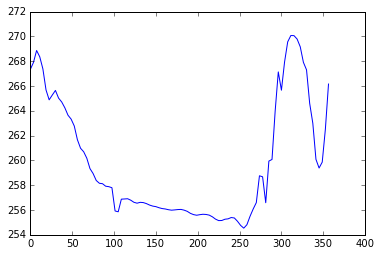

In [50]:
fname = iris.sample_data_path('air_temp.pp')
temperature = iris.load_cube(fname)

# Take a 1d slice using array style indexing.
temperature_1d = temperature[5, :]

iplt.plot(temperature_1d)
plt.show()

### interpolation

iris のinterpolationはSciPyに依存してるってさ

regriddingは、他のcubeのgridに対応させる時に使うみたい。必要になったら見てみよう。

In [2]:
import iris

# この出力からわかるように、interpolateした結果はscaler cubeで得られる
air_temp = iris.load_cube(iris.sample_data_path('air_temp.pp'))
sample_points = [('latitude', 51.48), ('longitude', 0)]
print(air_temp.interpolate(sample_points, iris.analysis.Linear()))

air_temperature / (K)               (scalar cube)
     Scalar coordinates:
          forecast_period: 6477 hours, bound=(-28083.0, 6477.0) hours
          forecast_reference_time: 1998-03-01 03:00:00
          latitude: 51.48 degrees
          longitude: 0 degrees
          pressure: 1000.0 hPa
          time: 1998-12-01 00:00:00, bound=(1994-12-01 00:00:00, 1998-12-01 00:00:00)
     Attributes:
          STASH: m01s16i203
          source: Data from Met Office Unified Model
     Cell methods:
          mean within years: time
          mean over years: time


In [3]:
# sample pointsは別に二次元分指定する必要はない。片方指定すれば、次元を残したcubeで返してくれる（すごくね？）
result = air_temp.interpolate([('longitude', 0)], iris.analysis.Linear())
print('Original: ' + air_temp.summary(shorten=True))
print('Interpolated: ' + result.summary(shorten=True))

Original: air_temperature / (K)               (latitude: 73; longitude: 96)
Interpolated: air_temperature / (K)               (latitude: 73)


In [6]:
# たくさんの点でinterpolateしたい時はこうすると早いみたいだよ
# cacheっていう

air_temp = iris.load_cube(iris.sample_data_path('air_temp.pp'))
interpolator = iris.analysis.Nearest().interpolator(air_temp, ['latitude', 'longitude'])

import numpy as np
latitudes = np.linspace(48, 60, 13)
longitudes = np.linspace(-11, 2, 14)
# resultは一点ずつの結果なので、まぁ別のものに詰め込んでください
for lat, lon in zip(latitudes, longitudes):
    result = interpolator([lat, lon])

### merge and concatenate

mergeは二次元を合わせて3次元にする、みたいに次元に変化が生じる行為

concatenateはもともと3次元のやつを合わせてより大きな3次元のcubeを作る行為

まぁこれも必要になったらでいいな。